In [17]:
from IPython.display import Audio
from utils import onset_plot
from utils import time_axies
from onset_classifier import onset_classifier
import matplotlib.pyplot as plt
import numpy as np
import librosa

# Hyper paramter
**Duration** controls the loaded length of sound  
**song_name** is the sound file

In [2]:
duration = 3
forward = 0.03
backward = 0.07
islog = True
comp = 1.0
song_name = './test_sounds/song004.wav'

# Load the music

In [3]:
y, sr = librosa.load(song_name, duration = duration)
Audio(y, rate=sr)

# Onset plot

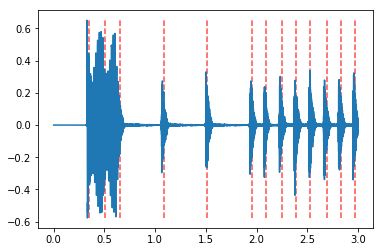

In [4]:
onset_plot(y, sr)

# Feature extractor based on the onsetclassifier

In [4]:
exclude_label, sound_type,features = onset_classifier(y, sr, model_name = 'DNN', forward=forward, backward=backward, islog=islog, comp=comp)

INFO:tensorflow:Restoring parameters from ./models_save/DNN/f0.03b0.07logTruecomp1.0/model


In [5]:
print(sr)

22050


In [6]:
print(exclude_label)
print(sound_type)
print(features.shape)

[0, 4]
{0: 'bass', 1: 'clap', 2: 'hihat', 3: 'kick', 4: 'percussion', 5: 'snare'}
(6, 66150)


In [7]:
nclasses, length = features.shape

select_features = []
for i in range(nclasses):
    if i in exclude_label:
        continue
    select_features.append(features[i])
select_features = np.array(select_features)

select_sound_type = []
for i in sound_type.keys():
    if i in exclude_label:
        continue
    select_sound_type.append(sound_type[i])

In [11]:
print(select_features.shape)
nclasses_r = select_features.shape[0]

(4, 66150)


In [12]:
# Add offset on each features to show everything at once
for i in range(nclasses_r):
    for j in range(length):
        select_features[i][j] += i+1

# Plot graph

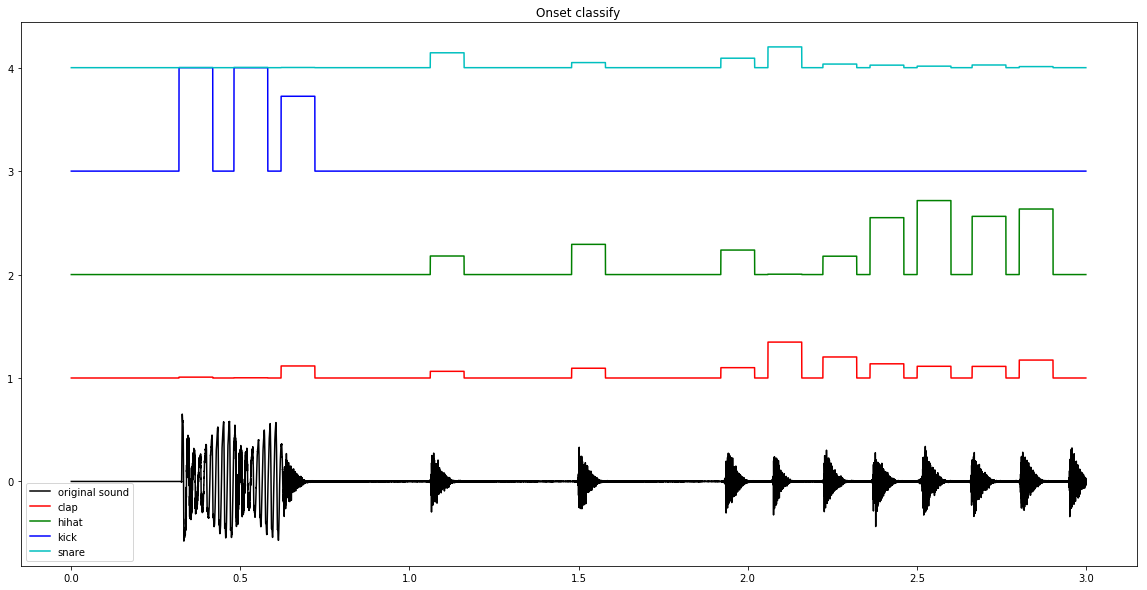

In [19]:
time = time_axies(y, sr)
plt.figure(figsize=(20,10))
plt.plot(time, y,'k', label = 'original sound')
color_pattern = 'rgbcmy'

for i in range(nclasses_r):
    plt.plot(time, select_features[i], color_pattern[i], label = select_sound_type[i])

plt.title("Onset classify")
plt.legend()
plt.show()
#plt.savefig("./asset/{}_duration({}).png".format(song_name[14:-4], duration))

# Animation

In [12]:
drate = 100

In [13]:
def downgrade(sound, rate):
    length = len(sound)
    length_r = int(length/rate)
    temp = np.zeros(length_r)
    for i in range(length_r):
        temp[i] = sound[i*rate]
    return temp

In [14]:
select_features_r = []
for i in range(len(select_features)):
    select_features_r.append(downgrade(select_features[i], drate))
    
select_features_r = np.array(select_features_r)
print(select_features_r.shape)

(4, 6615)


In [16]:
fps = 24
frames = int(len(y)/sr*fps)

time_axis =time_axies(select_features_r[0], sr/drate)
print(time_axis.shape)

ims = []
fig1 = plt.figure()

plt.xlabel("secs")

view_length = 3#secs

for nframe in range(frames):
    sub = plt.subplot(1,1,1)
    temp = int(nframe*sr/drate/fps)
    x_min = 0
    x_max = len(y)/sr
    if nframe/fps < view_length:
        x_max = view_length*2
    elif nframe/fps > len(y)/sr - view_length:
        x_min = len(y)/sr - view_length*2
    else :
        x_min = nframe/fps - view_length
        x_max = nframe/fps + view_length

    plot_min = int(x_min*sr/drate)
    plot_max = int(x_max*sr/drate)

    ims.append(sub.plot(time_axis[0:temp-plot_min], select_features_r[0][plot_min:temp], 'r-', 
                       time_axis[0:temp-plot_min], select_features_r[1][plot_min:temp], 'g-',
                       time_axis[0:temp-plot_min], select_features_r[2][plot_min:temp], 'b-',
                       time_axis[0:temp-plot_min], select_features_r[3][plot_min:temp], 'c-',
                       time_axis[temp-plot_min:plot_max-plot_min], select_features_r[0][temp:plot_max], 'k-', 
                       time_axis[temp-plot_min:plot_max-plot_min], select_features_r[1][temp:plot_max], 'k-',
                       time_axis[temp-plot_min:plot_max-plot_min], select_features_r[2][temp:plot_max], 'k-',
                       time_axis[temp-plot_min:plot_max-plot_min], select_features_r[3][temp:plot_max], 'k-')
              )

line_ani = animation.ArtistAnimation(fig1, ims, interval = int(1000/fps), blit= True)

(6615,)


In [ ]:
name = "./asset/{}_duration({})".format(song_name[14:-4], duration)
line_ani.save('{}.mp4'.format(name), fps = fps)

In [ ]:
1+1

In [16]:
librosa.output.write_wav('{}.wav'.format(name), y, sr)